In [1]:
import os
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
datapath = os.path.join('..', 'data')
filterpath = os.path.join(datapath, 'filters-final', '8_19')
num_filters = 8

In [4]:
import torch.nn as nn
import os
import matplotlib
device = torch.device('cpu')
nz=8
ngpu=1
netG_load = os.path.join(datapath, 'DCGAN_ind_generator' + '.pt')
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Linear(nz, 64),
            nn.BatchNorm1d(64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.Tanh(),
            nn.Linear(128, 25),
            # EDITED
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load(netG_load))

def visualise_dcgan(netG, num_rows, nz):
    _, axarr = plt.subplots(num_rows, 8, figsize=(int(5*(num_filters//8)), num_rows))
    plt.axis('off')

    uuids = os.listdir(filterpath)
    for f in range(num_rows):
        noise = torch.randn(8, nz, 1, 1, device=device)
        fake = netG(noise)
        for i in range(8):
            axarr[f, i].set_axis_off()
            axarr[f, i].imshow(fake[i].detach().reshape(5,5), norm=matplotlib.colors.Normalize(vmin=-2.5, vmax=2.5, clip=False), interpolation=None)

def histogram_dcgan(num_samples):

    uuids = os.listdir(filterpath)
    vals = []
    for f in range(num_samples // 8):
        noise = torch.randn(8, nz, 1, 1, device=device)
        fake = netG(noise)
        for i in range(8):
            vals.append(np.mean(fake[i].detach().reshape(5,5).numpy()))
    plt.hist(vals, bins=30)

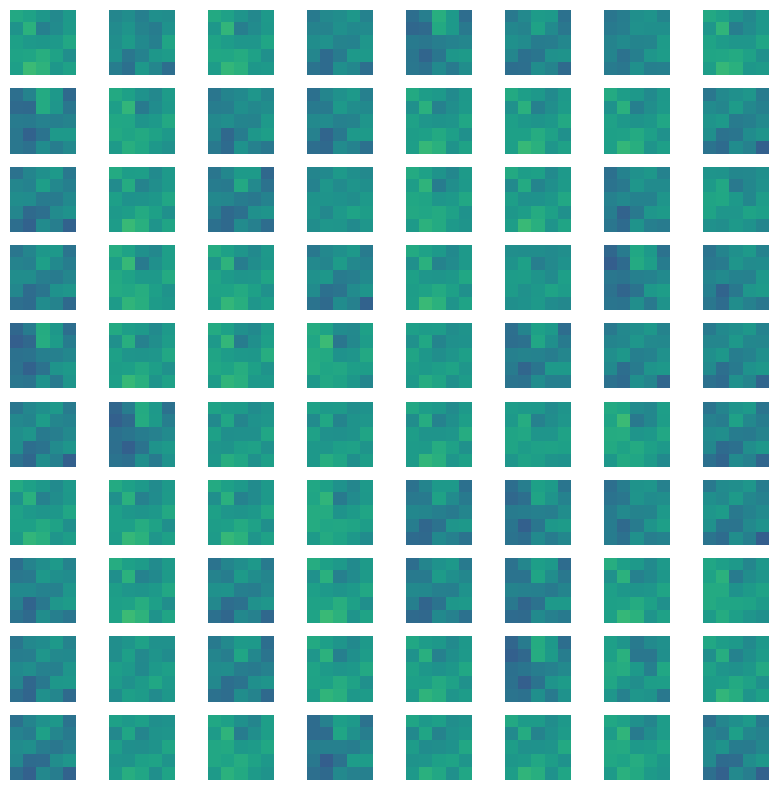

In [6]:
# histogram_dcgan(10000)
visualise_dcgan(netG, 10, nz)

In [7]:
import torch.nn as nn
import os
import matplotlib
device = torch.device('cpu')
nz=8
ngpu=1
netG_load = os.path.join(datapath, 'DCGAN_joint_generator' + '.pt')
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        self.merged = nn.Sequential(
            nn.Linear(nz, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Linear(64, 4*8),
        )
        self.shared_weights = nn.Sequential(
            nn.Linear(4, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Linear(64, 25),
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.shared_weights, input, range(self.ngpu))
        else:
            output = self.merged(input.view(-1,nz))
            
            acts = []
            for i  in range(8):
                sliced = output[:,i*(4):(i+1)*(4)].view(-1,4)
                sliced_output = self.shared_weights(sliced)
                acts.append(sliced_output.view(-1,1,5,5))
            output = torch.concat(acts, dim=1)

        return output

netG_joint = Generator(ngpu).to(device)
netG_joint.load_state_dict(torch.load(netG_load))

def visualise_dcgan_joint(netG, num_rows, nz):
    _, axarr = plt.subplots(num_rows, 8, figsize=(10, num_rows))
    plt.axis('off')

    uuids = os.listdir(filterpath)
    noise = torch.randn(num_rows, nz, device=device)
    fake = netG_joint(noise)
    for f in range(num_rows):   
        for i in range(8):
            axarr[f, i].set_axis_off()
            axarr[f, i].imshow(fake[f,i].detach().reshape(5,5), norm=matplotlib.colors.Normalize(vmin=-2.5, vmax=2.5, clip=False), interpolation=None)

def histogram_dcgan_joint(num_samples):

    uuids = os.listdir(filterpath)
    vals = []
    for f in range(num_samples // 8):
        noise = torch.randn(8, nz, device=device)
        fake = netG_joint(noise)
        for i in range(8):
            vals.append(np.mean(fake[0,i].detach().reshape(5,5).numpy()))
    plt.hist(vals, bins=30)


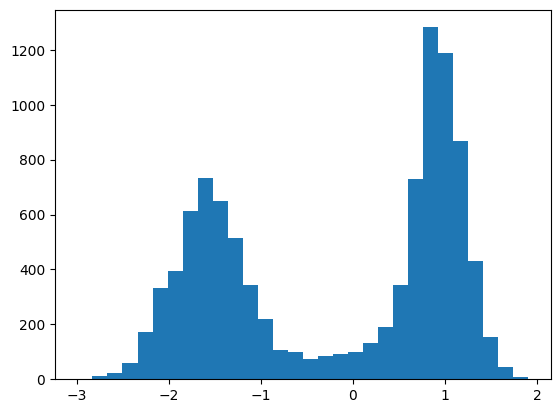

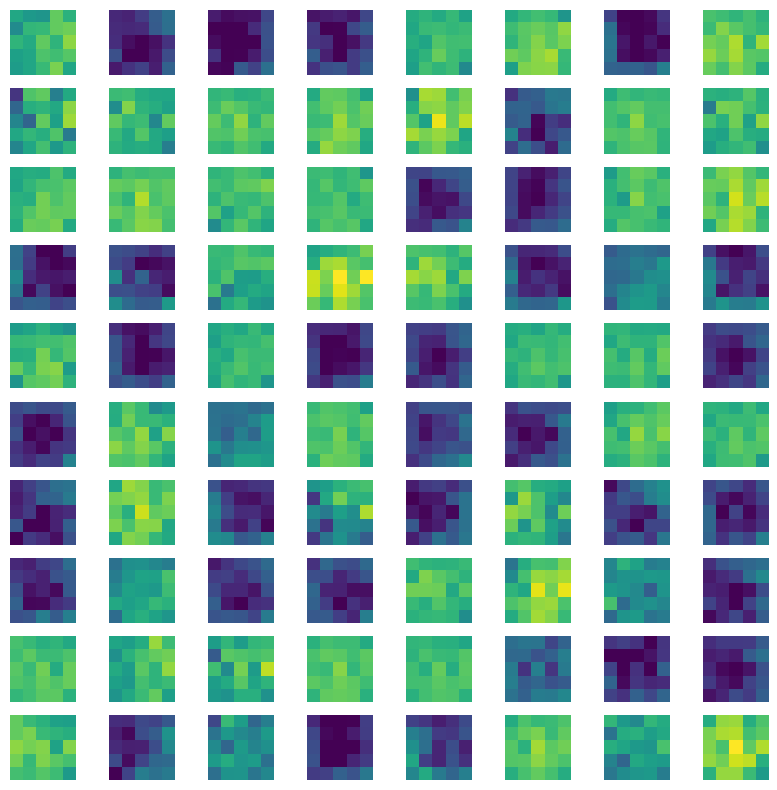

In [8]:
histogram_dcgan_joint(10000)
visualise_dcgan_joint(netG, 10, nz)